<a href="https://colab.research.google.com/github/darja/NeuralUni/blob/master/13_classic_ml_2_pro_ryazhskikh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классическое машинное обучение: признаки для разных типов данных

* Сделать классификатор открытый - закрытый глаз с помощью признаков для изображения. 
* Для зарузки файлов eyes_test.npz и eyes_train.npz использовать копию ноутбука dz_ml2_eyes.ipynb 
* [База](https://www.dropbox.com/s/bm1u6lkx6owy2fk/eyes.zip?dl=0)
* [Ноутбук](https://colab.research.google.com/drive/1AVbY3qihYa79B4O_jSg8xRBMjWhP6T43)
* В качестве признаков рекомендуется использовать одновременно HoG и LBP.
* Сам алгоритм может быть такой же, как в предыдущем домашнем задании для классического машинного обучения про классификатор лицо-не лицо. Только вместо интенсивностей используются признаки. Для одновременного использования признаков HoG и LBP можно сделать отдельно методы главных компонент для каждого типа признаков, сконкатенировать преобразованные признаки в один вектор и затем запускать классификатор, например SVM.
* В отчет - описание построенного классификатора и ошибки первого и второго рода, accuracy.
* Опционально - прогнать полученный алгоритм на базе лицо-не лицо
* Опционально - обучить сверточную сеть классифицировать открытый - закрытый глаз, лицо - не лицо.

# Подготовка окружения

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import hog, local_binary_pattern
from skimage import data, color, exposure

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics

import pandas as pd

## Чтение базы

### Подключение Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Распаковка базы

In [0]:
!cp /content/gdrive/'My Drive'/neural/eyes.zip eyes.zip
!unzip eyes.zip

Archive:  eyes.zip
  inflating: eyes_test.npz           
  inflating: eyes_train.npz          


### Чтение файлов

In [0]:
data = np.load('eyes_train.npz')
train_images = data["images"]
train_labels = data["labels"]

data = np.load('eyes_test.npz')
test_images = data["images"]
test_labels = data["labels"]

In [0]:
print("Train set: %s, labels: %s" % (train_images.shape, train_labels.shape))
print("Train labels: %s open, %s closed" % (sum(train_labels==1), sum(train_labels==0)))
print("\nTest set: %s, labels: %s" % (test_images.shape, test_labels.shape))
print("Test labels: %s open, %s closed" % (sum(test_labels==1), sum(test_labels==0)))


Train set: (3200, 24, 24), labels: (3200,)
Train labels: 1629 open, 1571 closed

Test set: (800, 24, 24), labels: (800,)
Test labels: 409 open, 391 closed


# Подготовка данных для классификатора

## Подготовка HOG-дескрипторов

### Чтение HoG-дескрипторов

In [0]:
to_hog = lambda image: hog(image, orientations=8, pixels_per_cell=(3, 3), cells_per_block=(1, 1), block_norm="L1", visualize=False)

# Train set
train_hog_raw = []
for img in train_images:
    train_hog_raw.append(to_hog(img))
train_hog_raw = np.array(train_hog_raw)
print("Train set hog descriptors: ", train_hog_raw.shape)

test_hog_raw = []
for img in test_images:
    test_hog_raw.append(to_hog(img))
test_hog_raw = np.array(test_hog_raw)
print("Test set hog descriptors: ", test_hog_raw.shape)


Train set hog descriptors:  (3200, 512)
Test set hog descriptors:  (800, 512)


#### Что не так с этим np.vectorize?

In [0]:
# почему не работает через vectorize?
hog_vec = np.vectorize(lambda image: hog(image, orientations=8, pixels_per_cell=(3, 3), cells_per_block=(1, 1), block_norm="L1", visualize=False), otypes=[np.ndarray])

test_images_hog = hog_vec(test_images)

In [0]:
test_images_hog.shape

(800, 24, 24)

In [0]:
test_images_hog

array([[[array([], dtype=float64), array([], dtype=float64),
         array([], dtype=float64), ..., array([], dtype=float64),
         array([], dtype=float64), array([], dtype=float64)],
        [array([], dtype=float64), array([], dtype=float64),
         array([], dtype=float64), ..., array([], dtype=float64),
         array([], dtype=float64), array([], dtype=float64)],
        [array([], dtype=float64), array([], dtype=float64),
         array([], dtype=float64), ..., array([], dtype=float64),
         array([], dtype=float64), array([], dtype=float64)],
        ...,
        [array([], dtype=float64), array([], dtype=float64),
         array([], dtype=float64), ..., array([], dtype=float64),
         array([], dtype=float64), array([], dtype=float64)],
        [array([], dtype=float64), array([], dtype=float64),
         array([], dtype=float64), ..., array([], dtype=float64),
         array([], dtype=float64), array([], dtype=float64)],
        [array([], dtype=float64), array([

### Нормализация

In [0]:
hog_mean = train_hog_raw.mean(0)
hog_std = train_hog_raw.std(0)
train_hog = np.zeros_like(train_hog_raw)
for i in range(0, train_hog_raw.shape[0]):
    train_hog[i,:]= (train_hog_raw[i,:] - hog_mean) / hog_std
print("Normalized hog descriptors: ", train_hog.shape)


Normalized hog descriptors:  (3200, 512)


### Выделение главных компонентов

512
Original train set: (3200, 512)
Transformed train set: (3200, 450)


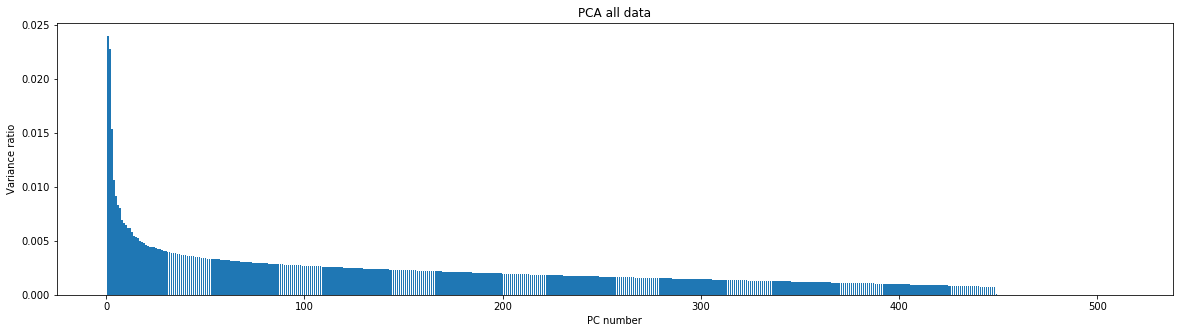

In [0]:
flen = train_hog.shape[1]
print(flen)

pca = PCA(n_components=flen)
pca.fit(train_hog)

plt.figure(figsize=(20, 5))
plt.bar(np.arange(1,flen+1), pca.explained_variance_ratio_)
plt.ylabel("Variance ratio")
plt.xlabel("PC number")
plt.title("PCA all data")

pca = PCA(n_components=450)
pca.fit(train_hog)

#преобразуем обучающую выборку
print("Original train set:", train_hog.shape)
train_hog_pca = pca.transform(train_hog)
print("Transformed train set:", train_hog_pca.shape)

### Преобразование тестового набора

In [0]:
test_hog = np.zeros_like(test_hog_raw)
for i in range(0, test_hog_raw.shape[0]):
    test_hog[i,:]= (test_hog_raw[i,:] - hog_mean) / hog_std
print(test_hog.shape)

print("Original test set:", test_hog.shape)
test_hog_pca = pca.transform(test_hog)
print("Transformed test set:", test_hog_pca.shape)

(800, 512)
Original test set: (800, 512)
Transformed test set: (800, 450)


## Подготовка LBP

### Чтение LBP

In [0]:
radius = 3
n_points = 8 * radius

lbp = lambda image: local_binary_pattern(image, n_points, radius)

# Train set
train_lbp_raw = []
for img in train_images:
    train_lbp_raw.append(lbp(img).ravel())
train_lbp_raw = np.array(train_lbp_raw)
print("Train set lbp: ", train_lbp_raw.shape)

test_lbp_raw = []
for img in test_images:
    test_lbp_raw.append(lbp(img).ravel())
test_lbp_raw = np.array(test_lbp_raw)
print("Test set lbp: ", test_lbp_raw.shape)


Train set lbp:  (3200, 576)
Test set lbp:  (800, 576)


### Нормализация

In [0]:
lbp_mean = train_lbp_raw.mean(0)
lbp_std = train_lbp_raw.std(0)
train_lbp = np.zeros_like(train_lbp_raw)
for i in range(0,train_lbp_raw.shape[0]):
    train_lbp[i,:]= (train_lbp_raw[i,:] - lbp_mean) / lbp_std

### Выделение главных компонентов

Transformed train set: (3200, 200)


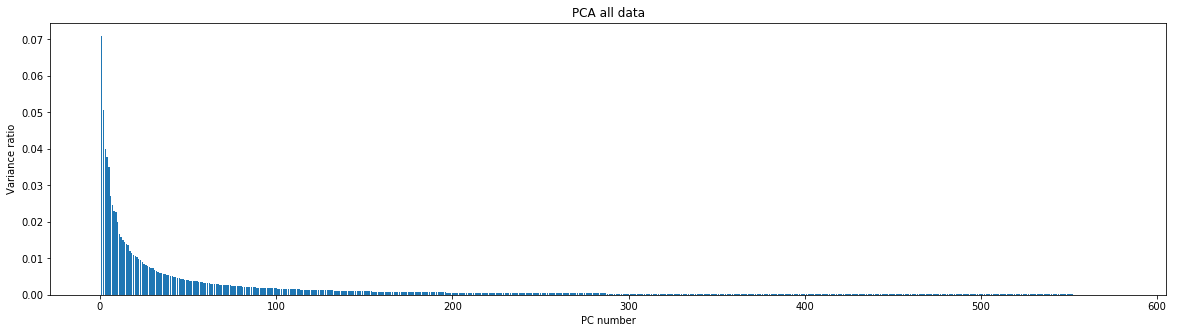

In [0]:
flen = train_lbp.shape[1]

pca = PCA(n_components=flen)
pca.fit(train_lbp)

plt.figure(figsize=(20, 5))
plt.bar(np.arange(1, flen+1), pca.explained_variance_ratio_)
plt.ylabel("Variance ratio")
plt.xlabel("PC number")
plt.title("PCA all data")

pca = PCA(n_components=200)
pca.fit(train_lbp)

#преобразуем обучающую выборку
train_lbp_pca = pca.transform(train_lbp)
print("Transformed train set:", train_lbp_pca.shape)

#### Преобразование тестового набора

In [0]:
test_lbp = np.zeros_like(test_lbp_raw)
for i in range(0, test_lbp_raw.shape[0]):
    test_lbp[i,:]= (test_lbp_raw[i,:] - lbp_mean) / lbp_std

print("Original test set:", test_lbp.shape)
test_lbp_pca = pca.transform(test_lbp)
print("Transformed test set:", test_lbp_pca.shape)

Original test set: (800, 576)
Transformed test set: (800, 200)


## Объединение HoG- и LBP-компонентов

In [0]:
def union_features(im_hog, im_lbp):
    train_set = []
    for i in range(0, im_hog.shape[0]):
        train_set.append(np.append(im_hog[i], im_lbp[i]))
    train_set = np.array(train_set)
    return train_set
    

train_combined_pca = union_features(train_hog_pca, train_lbp_pca)
print("Train data\n\tHoG: %s\n\tLBP: %s\n\tCombined: %s" % (train_hog_pca.shape, train_lbp_pca.shape, train_combined_pca.shape))

test_combined_pca = union_features(test_hog_pca, test_lbp_pca)
print("\n\nTrain data\n\tHoG: %s\n\tLBP: %s\n\tCombined: %s" % (test_hog_pca.shape, test_lbp_pca.shape, test_combined_pca.shape))


Train data
	HoG: (3200, 450)
	LBP: (3200, 200)
	Combined: (3200, 650)


Train data
	HoG: (800, 450)
	LBP: (800, 200)
	Combined: (800, 650)


# Классификация

## Утилиты

In [0]:
#вычисление ошибок первого и второго рода
def calculate_errors(expected, predicted):    
    acc = metrics.accuracy_score(expected, predicted)
    FP = sum((expected == 0) & (predicted == 1))
    FN = sum((expected == 1) & (predicted == 0))
    TP = sum((expected == 1) & (predicted == 1))
    TN = sum((expected == 0) & (predicted == 0))
    FPR = FP / (FP + TN)
    FNR = FN / (TP + FN)
    return (FPR, FNR, acc)

def print_errors(expected, predicted):    
    FPR, FNR, acc = calculate_errors(expected, predicted)
    print("Accuracy:", acc)
    print('ERR1 ', FPR)
    print('ERR2 ', FNR)
    return (FPR, FNR, acc)

def fit_and_predict(classifier, classifier_name, dataset_name, train_set, test_set, result_accum):
    classifier.fit(train_set, train_labels)

    predicted = classifier.predict(test_set)
    FPR, FNR, acc = calculate_errors(test_labels, predicted)    
    result_accum = result_accum.append({"Classifier": classifier_name, "Dataset": dataset_name, "FPR": FPR, "FNR": FNR, "TFR": FPR + FNR, "Accuracy": acc}, ignore_index=True)
    return result_accum
    
def fit_and_predict_all_datasets(create_classifier, classifier_string, result_accum, verbose = False):
    if verbose:
        print("Performing HoG classification")
    result_accum = fit_and_predict(create_classifier(), classifier_string, "HoG only", train_hog, test_hog, result_accum)

    if verbose:
        print("Performing HoG PCA classification")
    result_accum = fit_and_predict(create_classifier(), classifier_string, "HoG PCA", train_hog_pca, test_hog_pca, result_accum)

    if verbose:
        print("Performing LBP classification")
    result_accum = fit_and_predict(create_classifier(), classifier_string, "LBP only", train_lbp, test_lbp, result_accum)

    if verbose:
        print("Performing LBP PCA classification")
    result_accum = fit_and_predict(create_classifier(), classifier_string, "LBP PCA", train_lbp_pca, test_lbp_pca, result_accum)
    
    if verbose:
        print("Performing Combined HoG + LBP PCA classification")
    result_accum = fit_and_predict(create_classifier(), classifier_string, "HoG PCA + LBP PCA", train_combined_pca, test_combined_pca, result_accum)
    return result_accum


## Классификация с помощью SVC

In [0]:
result = pd.DataFrame(columns=['Classifier', 'Dataset', 'FPR', 'FNR', 'TFR', "Accuracy"])

result = fit_and_predict_all_datasets(lambda: SVC(gamma="auto"), "Auto", result, True)

Performing HoG classification
Performing HoG PCA classification
Performing LBP classification
Performing LBP PCA classification
Performing Combined HoG + LBP PCA classification


In [0]:
result

,Classifier,Dataset,FPR,FNR,TFR,Accuracy
0,Auto,HoG only,0.056266,0.075795,0.132061,0.93375
1,Auto,HoG PCA,0.056266,0.075795,0.132061,0.93375
2,Auto,LBP only,0.058824,0.058680,0.117503,0.94125
3,Auto,LBP PCA,0.063939,0.056235,0.120173,0.94000
4,Auto,HoG PCA + LBP PCA,0.028133,0.051345,0.079478,0.96000


## Подбор параметров

In [0]:
gamma_range =  np.arange(1, 10)
gamma_range

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [0]:
gamma_range = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 0.5, 1, 1,5, 2]
C_range = np.arange(1, 5)

n_exp = len(gamma_range) * len(C_range)
# FPR - False Positive Rate
# FNR - False Negative Rate
# TFR - Total False Rate
result = pd.DataFrame(columns=['Classifier', 'Dataset', 'FPR', 'FNR', 'TFR', "Accuracy"])

i = 1
for gamma in gamma_range:
    for C in C_range:
        classifier_name = "C=%s, gamma=%s" % (C, gamma)
        print("%s of %s: %s" % (i, n_exp, classifier_name))
        i += 1
        result = fit_and_predict_all_datasets(lambda: SVC(C = C, gamma = gamma), classifier_name, result)


1 of 44: C=1, gamma=0.0001
2 of 44: C=2, gamma=0.0001
3 of 44: C=3, gamma=0.0001
4 of 44: C=4, gamma=0.0001
5 of 44: C=1, gamma=0.0005
6 of 44: C=2, gamma=0.0005
7 of 44: C=3, gamma=0.0005
8 of 44: C=4, gamma=0.0005
9 of 44: C=1, gamma=0.001
10 of 44: C=2, gamma=0.001
11 of 44: C=3, gamma=0.001
12 of 44: C=4, gamma=0.001
13 of 44: C=1, gamma=0.005
14 of 44: C=2, gamma=0.005
15 of 44: C=3, gamma=0.005
16 of 44: C=4, gamma=0.005
17 of 44: C=1, gamma=0.01
18 of 44: C=2, gamma=0.01
19 of 44: C=3, gamma=0.01
20 of 44: C=4, gamma=0.01
21 of 44: C=1, gamma=0.05
22 of 44: C=2, gamma=0.05
23 of 44: C=3, gamma=0.05
24 of 44: C=4, gamma=0.05
25 of 44: C=1, gamma=0.5
26 of 44: C=2, gamma=0.5
27 of 44: C=3, gamma=0.5
28 of 44: C=4, gamma=0.5
29 of 44: C=1, gamma=1
30 of 44: C=2, gamma=1
31 of 44: C=3, gamma=1
32 of 44: C=4, gamma=1
33 of 44: C=1, gamma=1
34 of 44: C=2, gamma=1
35 of 44: C=3, gamma=1
36 of 44: C=4, gamma=1
37 of 44: C=1, gamma=5
38 of 44: C=2, gamma=5
39 of 44: C=3, gamma=5
40 of 44

### Gamma = Auto

In [0]:
i = 0
n_auto = len(C_range)
for C in C_range:
    classifier_name = "C=%s, gamma=Auto" % C
    print("%s of %s: %s" % (i, n_auto, classifier_name))
    i += 1
    result = fit_and_predict_all_datasets(lambda: SVC(C = C, gamma = "auto"), classifier_name, result)


0 of 4: C=1, gamma=Auto
1 of 4: C=2, gamma=Auto
2 of 4: C=3, gamma=Auto
3 of 4: C=4, gamma=Auto


### Лучшие результаты подбора

In [0]:
result.sort_values(by=['TFR', 'FNR'])

,Classifier,Dataset,FPR,FNR,TFR,Accuracy
224,"C=1, gamma=Auto",HoG PCA + LBP PCA,0.028133,0.051345,0.079478,0.96000
229,"C=2, gamma=Auto",HoG PCA + LBP PCA,0.030691,0.051345,0.082035,0.95875
234,"C=3, gamma=Auto",HoG PCA + LBP PCA,0.030691,0.053790,0.084480,0.95750
239,"C=4, gamma=Auto",HoG PCA + LBP PCA,0.030691,0.053790,0.084480,0.95750
44,"C=1, gamma=0.001",HoG PCA + LBP PCA,0.038363,0.046455,0.084818,0.95750
59,"C=4, gamma=0.001",HoG PCA + LBP PCA,0.046036,0.041565,0.087601,0.95625
54,"C=3, gamma=0.001",HoG PCA + LBP PCA,0.046036,0.044010,0.090046,0.95500
49,"C=2, gamma=0.001",HoG PCA + LBP PCA,0.046036,0.048900,0.094936,0.95250
9,"C=2, gamma=0.0001",HoG PCA + LBP PCA,0.040921,0.056235,0.097155,0.95125
24,"C=1, gamma=0.0005",HoG PCA + LBP PCA,0.040921,0.056235,0.097155,0.95125
